In [5]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import numpy as np
import pandas as pd
import yfinance as yf
import sys


The following code defines a function create_pairs_dataframe that takes a directory path (datadir) and a list of stock symbols (symbols). It uses the yfinance library to download historical stock data for two symbols specified in the input list. The function then constructs a Pandas DataFrame containing the adjusted closing prices of the two stocks, aligning them based on the date index. The resulting DataFrame (pairs) is returned, representing a dataset with pairs of stock prices for further analysis.

In [2]:
def create_pairs_dataframe(datadir, symbols):
    print("Importing CSV Data")

    sym1 = yf.download(symbols[0], start='2022-06-01', end=time.strftime("%Y-%m-%d"))
    sym2 = yf.download(symbols[1], start='2022-06-01', end=time.strftime("%Y-%m-%d"))

    print("Constructing dual matrix for %s and %s" % tuple(symbols))
    pairs = pd.DataFrame(index=sym1.index)
    pairs['%s_close' % symbols[0]] = sym1['Adj Close']
    pairs['%s_close' % symbols[1]] = sym2['Adj Close']
    pairs = pairs.dropna()
    return pairs

In [3]:
def check_cointegration(pairs, symbols):
    print("Computing Cointegration")
    coin_result = sm.tsa.coint(pairs['%s_close' % symbols[0]], pairs['%s_close' % symbols[1]])  # Cointegration calculating
    return coin_result[1]



In [4]:
def calculate_spread_zscore(pairs, symbols):

    pairs['returns']=np.log(pairs['%s_close' % symbols[0]]/pairs['%s_close' %symbols[1]])
    pairs['mean']=pairs['returns'].rolling(window=30,center=False).mean()
    pairs = pairs.dropna()

    print("Creating the spread/zscore columns")

    pairs['zscore'] = (pairs['returns'] - pairs['mean'])/pairs['returns'].rolling(window=30,center=False).std()

    pairs['returns'].rolling(window=30,center=False).std()
    return pairs


Let us define a function signal_generate that takes a DataFrame of stock pairs (pairs), a list of stock symbols (symbols), and optional threshold parameters for generating trading signals. It calculates trading signals based on a z-score strategy.

Long signals are generated when the z-score is below a negative entry threshold (z_entry_threshold).
Short signals are generated when the z-score is above a positive entry threshold (z_entry_threshold).
Exit signals are generated when the absolute z-score is below a lower exit threshold (z_exit_threshold1) or above an upper exit threshold (z_exit_threshold2).
The function iterates through the DataFrame to determine when to enter and exit long and short positions in the market based on the calculated signals. The results are stored in additional columns ('longs', 'shorts', 'exits', 'long_market', 'short_market') in the DataFrame, which is then returned.

In [6]:
def signal_generate(pairs, symbols,
                    z_entry_threshold=2.0,
                    z_exit_threshold1=0.5,
                    z_exit_threshold2=3.5):

    pairs['longs'] = (pairs['zscore'] <= -z_entry_threshold).astype(float)
    pairs['shorts'] = (pairs['zscore'] >= z_entry_threshold).astype(float)

    pairs['exits'] = (np.abs(pairs['zscore']) <= z_exit_threshold1).astype(float)

    pairs['long_market'] = 0.0
    pairs['short_market'] = 0.0

    long_market = 0
    short_market = 0

    print("Calculating when to be in the market (long and short)")
    for i in range(1, len(pairs)):
        if pairs['longs'][i-1] == 1.0:
            long_market = 1
        if pairs['shorts'][i-1] == 1.0:
            short_market = 1

        if pairs['exits'][i-1] == 1.0 or ((np.abs(pairs['zscore'][i] - pairs['zscore'][i-1]) > 1) and (np.abs(pairs['zscore'][i] + pairs['zscore'][i-1]) < 1)):
            pairs.at[pairs.index[i-1], 'exits'] = 1
            long_market = 0
            short_market = 0

        pairs.at[pairs.index[i], 'long_market'] = long_market
        pairs.at[pairs.index[i], 'short_market'] = short_market

    return pairs


In [7]:
def portfolio_returns(pairs, symbols, lot_size):
    sym1 = symbols[0]
    sym2 = symbols[1]

    pairs['ret_%s' % symbols[0]] = 100 * ((pairs['%s_close' % sym1] / pairs['%s_close' % sym1].shift(1)) - 1)
    pairs['ret_%s' % symbols[1]] = 100 * ((pairs['%s_close' % sym2] / pairs['%s_close' % sym2].shift(1)) - 1)

    print("Constructing a portfolio")
    portfolio = pd.DataFrame(index=pairs.index)
    portfolio['positions'] = pairs['long_market'] - pairs['short_market']

    pairs[sym1] = pairs['ret_%s' % symbols[0]] * portfolio['positions']
    pairs[sym2] = -1.0 * pairs['ret_%s' % symbols[1]] * portfolio['positions']

    pairs['total'] = pairs[sym1] + pairs[sym2]

    portfolio['total'] = pairs['total']

    print("Constructing the equity curve")
    portfolio['returns'] = portfolio['total'].pct_change()
    portfolio['returns'].fillna(0.0, inplace=True)
    portfolio['returns'].replace([np.inf, -np.inf], 0.0, inplace=True)
    portfolio['returns'].replace(-1.0, 0.0, inplace=True)

    portfolio['cumu_sum'] = portfolio['total'].cumsum()
    portfolio['cumu_sum'].plot()
    (100 * np.log(pairs['%s_close' % symbols[0]] / pairs['%s_close' % symbols[0]].shift(1))).cumsum().plot()
    (100 * np.log(pairs['%s_close' % symbols[1]] / pairs['%s_close' % symbols[1]].shift(1))).cumsum().plot()
    plt.xlabel("Date and time")
    plt.ylabel("Cumulative Returns in %")
    plt.grid(True)

    return portfolio

Define a function portfolio_returns that computes and visualizes the cumulative returns of a portfolio based on trading signals generated from a pairs trading strategy.

It calculates the daily returns for each stock in the pair.
Constructs a portfolio by taking long or short positions based on the signals generated in the 'long_market' and 'short_market' columns.
Computes the total returns for the portfolio, creating an equity curve.
Plots the cumulative returns of the portfolio and the individual stocks over time.
The resulting portfolio DataFrame contains columns for positions, total returns, cumulative returns, and visualizations of the cumulative returns of the portfolio and individual stocks. The function returns the portfolio DataFrame for further analysis. Note: This code assumes that the necessary libraries (such as Pandas, NumPy, and Matplotlib) are imported elsewhere in the script.

Importing CSV Data
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Constructing dual matrix for RELIANCE.NS and ADANIPOWER.NS
Computing Cointegration
Pairs are cointegrated
coint_check
Creating the spread/zscore columns
Calculating when to be in the market (long and short)
Constructing a portfolio
Constructing the equity curve


<ipython-input-4-b665bc7e86a2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairs['zscore'] = (pairs['returns'] - pairs['mean'])/pairs['returns'].rolling(window=30,center=False).std()
<ipython-input-6-803dfdc737d3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairs['longs'] = (pairs['zscore'] <= -z_entry_threshold).astype(float)
<ipython-input-6-803dfdc737d3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

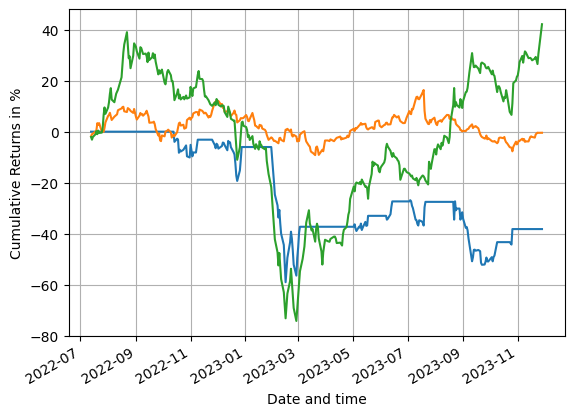

In [9]:
datadir="H:\QuantPairsTrading\EquityDetails"

if __name__ == "__main__":
    datadir = "H:\QuantPairsTrading\EquityDetails"
    symbols = ('RELIANCE.NS', 'ADANIPOWER.NS')
    lot_size = (2500, 400)
    returns = []

    pairs = create_pairs_dataframe(datadir, symbols)
    coint_check = check_cointegration(pairs, symbols)

    if coint_check < 0.47:
        print("Pairs are cointegrated")
        print('coint_check')

        pairs = calculate_spread_zscore(pairs, symbols)
        pairs = signal_generate(pairs, symbols,
                                z_entry_threshold=2.0,
                                z_exit_threshold1=0.5,
                                z_exit_threshold2=3.5)

        portfolio = portfolio_returns(pairs, symbols, lot_size)
        pairs.to_csv("H:\QuantPairsTrading\EquityDetails\op.csv")

    else:
        print("coint_check")
        print("Pairs are not cointegrated. Failed order")